In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from datetime import datetime
from numpy.random import randn,randint
from pandas import DataFrame, Series
from bb_binary import Repository, load_frame_container
from scipy import stats

# Command so that plots appear in the iPython Notebook
%matplotlib inline

In [8]:
base = "../00_Data/testset_2015_1h/"
#folder0 = "2015082215"
#folder1 = "2015092215"
folder2 = "2015102215"

folder_list = [folder0, folder1, folder2]

In [9]:
def createDF(repo, sample):
    cam0 = list(repo.iter_fnames(cam=0))[0]
    cam1 = list(repo.iter_fnames(cam=1))[0]
    cam2 = list(repo.iter_fnames(cam=2))[0]
    cam3 = list(repo.iter_fnames(cam=3))[0]
    files = [cam0, cam1, cam2, cam3]
    
    df = DataFrame()

    # Für jede Datei die Frames einlesen und an DataFrame anhängen
    for f in files:

        # id - ID des FrameContainers
        # frameIdx - ID von einem Frame: 0 - 1023
        # idx - ID einer Detection: kommt drauf an wie viele es so gibt

        fc = load_frame_container(f)

        for f in fc.frames:
            # alle Detections von einem Frame
            det = DataFrame([d.to_dict() for d in f.detectionsUnion.detectionsDP])
            det['frame_idx'] = f.frameIdx
            det['cam_id'] = fc.camId
            det['fc_id'] = fc.id
            det = det.set_index(['fc_id', 'frame_idx', 'idx'])
            df = pd.concat([df, det])
    
    df.drop(['descriptor', 'localizerSaliency', 'xposHive', 'yposHive', 'xRotation', 'yRotation'], axis=1, inplace=True)
    return df

In [10]:
def get_binary_bit(bit, threshold):
    if (bit <= threshold):
        return 0
    
    if (bit >= 255-threshold):
        return 1
    
    else:
        return np.nan

# Zum ausrechnen der IDs
def get_detected_id(id):
    
    threshold = 30
    
    # Umrechnen in binary array [0,1,1,1,0,1,1,1,0,0,0,1]
    # Ids die nicht umgerechnet werden können, weil außerhalb des threshold, werden NAN
    binary_id = [get_binary_bit(i, threshold) for i in id]

    decimal_id = np.nan

    if not np.isnan(binary_id).any():
        # convert to decimal id using 11 least significant bits
        decimal_id = int(''.join([str(c) for c in binary_id[:11]]), 2)

        # determine what kind of parity bit was used and add 2^11 to decimal id
        # uneven parity bit was used
        if ((sum(binary_id) % 2) == 1):
            decimal_id += 2048

    return decimal_id

In [11]:
def print_stat_ids(df, f):
    df['id'] = df.decodedId.apply(get_detected_id)
    print(f)
    print("Number of Detections: {}".format(df.shape[0]))
    df = df.dropna()
    print("Number of dropping na values: {}".format(df.shape[0]))


In [13]:
for f in folder_list:
    r = Repository(base+f)
    df = createDF(r, f)
    print_stat_ids(df,f)

2015082215
Number of Detections: 481457
Number of dropping na values: 353672
2015092215
Number of Detections: 198039
Number of dropping na values: 148626
2015102215
Number of Detections: 46331
Number of dropping na values: 33508


### Bees facing each other?

In [162]:
df1 = df_ids[df_ids.cam_id == 1]
df1.head()

xpos  ypos  zRotation  cam_id      id
fc_id                frame_idx idx                                       
-8311852132518586800 0         1      49  2125   1.808376       1  1313.0
                               2      64  1914   0.752673       1  1937.0
                               3      86  1149   2.772051       1  1756.0
                               4     124  1724  -2.471518       1   749.0
                               5     148  1300   2.375421       1  1408.0

In [163]:
df1['key'] = 1
gr = df1.groupby(level = 'frame_idx')

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [164]:
merged = DataFrame()

for i, g in gr:
    cartprodukt = pd.merge(g, g, on='key')
    merged = pd.concat([merged, cartprodukt])
    
print(merged.shape)

(2703732, 11)


In [165]:
merged.columns

merged = merged[merged.id_x < merged.id_y]
merged = merged.drop('key', axis=1)

In [166]:
merged.head()

,xpos_x,ypos_x,zRotation_x,cam_id_x,id_x,xpos_y,ypos_y,zRotation_y,cam_id_y,id_y
1,49,2125,1.808376,1,1313.0,64,1914,0.752673,1,1937.0
2,49,2125,1.808376,1,1313.0,86,1149,2.772051,1,1756.0
4,49,2125,1.808376,1,1313.0,148,1300,2.375421,1,1408.0
7,49,2125,1.808376,1,1313.0,214,2364,1.183083,1,1977.0
10,49,2125,1.808376,1,1313.0,339,2249,-0.490967,1,1861.0


In [167]:
merged.loc[:, 'dist'] = np.sqrt(np.square(merged.xpos_x - merged.xpos_y) + np.square(merged.ypos_x - merged.ypos_y))

In [168]:
merged.head()

,xpos_x,ypos_x,zRotation_x,cam_id_x,id_x,xpos_y,ypos_y,zRotation_y,cam_id_y,id_y,dist
1,49,2125,1.808376,1,1313.0,64,1914,0.752673,1,1937.0,211.532503
2,49,2125,1.808376,1,1313.0,86,1149,2.772051,1,1756.0,976.701080
4,49,2125,1.808376,1,1313.0,148,1300,2.375421,1,1408.0,830.918769
7,49,2125,1.808376,1,1313.0,214,2364,1.183083,1,1977.0,290.423828
10,49,2125,1.808376,1,1313.0,339,2249,-0.490967,1,1861.0,315.398161


In [ ]:
# def looksat(xpos, xrot, ypos, yrot):
#     return (xrot.dot(ypos - xpos))>0, (yrot.dot(xpos-ypos))>0

# xpos = np.array([1,1])
# ypos = np.array([3,2])
# xrot = np.array([0,1])
# yrot = np.array([1,1])

# looksat(xpos, xrot, ypos, yrot)

# yrot = np.array([-1,-1])
# looksat(xpos, xrot, ypos, yrot)

# xrot = np.array([-1,-1])
# looksat(xpos, xrot, ypos, yrot)

In [169]:
def facing(xpos_x, ypos_x, angle_x, xpos_y, ypos_y, angle_y):
    
    A = np.array(np.array([xpos_x, ypos_x]))
    angleA = np.array((np.cos(angle_x), np.sin(angle_x)))
    
    B = np.array(np.array([xpos_y, ypos_y]))
    angleB = np.array((np.cos(angle_y), np.sin(angle_y)))
    
    ab = (angleA.dot(B-A)) > 0
    ba = (angleB.dot(A-B)) > 0
    
    return ab & ba

In [170]:
facing(2,2, np.pi/2, 4,4, 0)

False

In [131]:
# merged['facing'] = map(facing,
#                        merged.xpos_x, merged.ypos_x, merged.zRotation_x,
#                        merged.xpos_y, merged.ypos_y, merged.zRotation_y)

In [ ]:
# merged['facing'] = facing(merged.xpos_x, merged.ypos_x, merged.zRotation_x,
#                          merged.xpos_y, merged.ypos_y, merged.zRotation_y)

In [171]:
merged['facing'] = merged.apply((lambda x: facing(x.xpos_x, x.ypos_x, x.zRotation_x,
                                                  x.xpos_y, x.ypos_y, x.zRotation_y)), axis=1)


In [172]:
merged[merged.facing == True].head()

,xpos_x,ypos_x,zRotation_x,cam_id_x,id_x,xpos_y,ypos_y,zRotation_y,cam_id_y,id_y,dist,facing
16,49,2125,1.808376,1,1313.0,624,2775,2.942781,1,1733.0,867.827748,True
21,49,2125,1.808376,1,1313.0,687,2425,2.849189,1,1412.0,705.013475,True
31,49,2125,1.808376,1,1313.0,923,2650,2.743015,1,1564.0,1019.559218,True
53,49,2125,1.808376,1,1313.0,2562,2850,-2.918107,1,1780.0,2615.491158,True
79,64,1914,0.752673,1,1937.0,837,1263,1.021201,1,3762.0,1010.608727,True


In [173]:
true = len(merged[merged.facing == True])

In [174]:
false = len(merged[merged.facing == False])

In [176]:
true

348675

In [177]:
false

976967

In [178]:
true+false

1325642

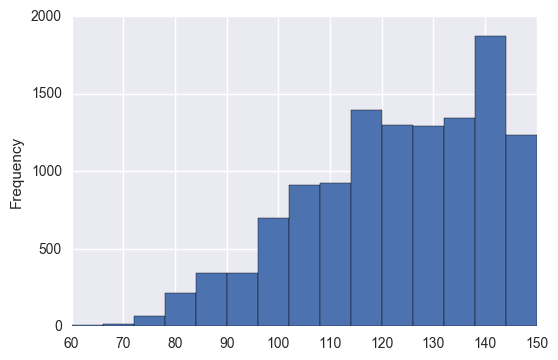

In [189]:
ms = merged[merged.dist <= 150]
ms.dist.plot.hist(bins=(15))

In [197]:
100*ms.shape[0]/merged.shape[0]

0.9016008847034116

In [201]:
true = ms[ms.facing == True].shape[0]
true

2958

In [202]:
false = ms[ms.facing == False].shape[0]
false

8994

In [87]:
test = DataFrame({"A":[1,2,3], "B":[11,22,33], "C":[10,20,30]})

In [70]:
test

,A,B,C
0,1,11,10
1,2,22,20
2,3,33,30


In [116]:
def function(a,s,c):
    return a+s+c

In [117]:
test['erg'] = test.apply(lambda row: row.A+row.B+row.C, axis=1)

In [137]:
test['erg2'] = map(function, test['A'], test['B'], test['C'])

In [138]:
test

,A,B,C,erg,erg2
0,1,11,10,22,<map object at 0x10b818b38>
1,2,22,20,44,<map object at 0x10b818b38>
2,3,33,30,66,<map object at 0x10b818b38>
